In [1]:

import os
import json
import glob
import copy
import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd

from scipy import stats as spstats

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.utils import natural_keys, label_figure

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/applica

In [2]:
%matplotlib notebook

# Test a dataset

# Set responsivity params

In [3]:
responsive_test = 'nstds'
responsive_thr = 10.
n_stds = 2.5
experiment_type = 'blobs'

# Get aggregate data

In [4]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
print aggregate_dir

/n/coxfs01/julianarhee/aggregate-visual-areas


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_inst

In [5]:
sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)
dsets = sdata[sdata['experiment']==experiment_type]

In [6]:
stats_desc = util.get_stats_desc(traceid=optsE.traceid,
                                      trace_type= optsE.trace_type,
                                      response_type = response_type,
                                      responsive_test = responsive_test,
                                      responsive_thr = responsive_thr,
                                      n_stds = n_stds)
print(stats_desc)

stats-traces001-corrected-dff-nstds-thr-10.00


# Create output dir for analysis


In [7]:
outdir = os.path.join(aggregate_dir, '%s-tuning' % experiment_type, stats_desc)
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/stats-traces001-corrected-dff-nstds-thr-10.00


In [8]:
def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


In [9]:
# Set plotting params
threshold_dff = True
min_dff = 0.03

n_sz = 5
n_mp = 10



# Select data

IGNORE THESE:
V1:  JC076-20190501, JC083-20190510
    - if blobs & rfs only: ignore JC083_20190511, else ALSO ignore: 20190507-JC083
Lm:  JC078-20190509, JC080-20190506, JC083-20190517
    - if blobs & rfs only: ignore JC078-2019513, else ALSO ignore: JC078-20190430
    - if blobs & rfs only: ignore JC083-20190512, else ALSO ignore: JC083-20190508
Li:  JC076-20190422, JC099-20190509, JC091-20190607, JC091-20190606
    

In [119]:
always_exclude = ['JC076-20190501', 'JC083-20190510', 
                  'JC078-20190426', 'JC078-20190509', 'JC080-20190506', 'JC083-20190517',
                 'JC076-20190422', 'JC099-20190509', 'JC091-20190607', 'JC091-20190606']
also_exclude = ['JC078-2019513', 'JC083-20190512']

excluded_sessions = copy.copy(always_exclude)
excluded_sessions.extend(also_exclude)
print(len(excluded_sessions))

12


# Select dataset

In [13]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084' #'JC059'
session = '20190522' #'20190227'
fov = 'FOV1_zoom2p0x' #'FOV4_zoom4p0x'
traceid = 'traces001' #'traces001'
response_type = 'dff'


In [14]:
data_id = '|'.join([animalid, session, fov, traceid, stats_desc])

exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# Get stimulus conditions
sdf = exp.get_stimuli()
sdf = reformat_morph_values(sdf)
sizes = np.array(sorted(sdf['size'].unique()))
morphs = np.array(sorted(sdf['morphlevel'].unique()))

n_sizes = len(sdf['size'].unique())
n_morphs = len(sdf['morphlevel'].unique()) 
if n_sizes != n_sz or n_morphs != n_mp:
    incorrect_nvalues.append(skey)
    pass

rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                             response_type=response_type, responsive_test=responsive_test,
                             responsive_thr=responsive_thr, n_stds=n_stds)
rstats = rstats['nframes_above']

# Get metrics for each condition
estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                   for roi in estats.rois], axis=1).T

# Get ROI list
if threshold_dff:
    rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
else:
    rois_plot = meanr.index.tolist()
print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))


... [JC084|20190522|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_ea0b53_traces001_92d492_traces001_af4cfd_traces001_9188fa_traces001_b44714_traces001_133108/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 168 of 180 responsive cells.


# Get all trials

In [63]:
dflist = [pd.DataFrame(estats.gdf.get_group(roi).sort_values(by='trial')['dff']).reset_index(drop=True)\
          for roi in rois_plot]
          
df = pd.concat(dflist, axis=1)
df.columns = rois_plot

In [66]:
print df.shape
df.head()


(1500, 168)


,1,5,6,9,10,11,12,14,17,18,...,238,239,241,242,243,246,249,251,255,258
0,0.239952,-0.024001,0.019147,0.628262,0.127027,1.306773,0.611393,0.315377,0.549193,0.840671,...,0.463303,0.163610,0.575956,0.186751,0.129041,0.697019,0.777087,0.125536,0.095211,1.381889
1,0.284643,0.000722,-0.008510,0.522548,0.084995,-0.135453,0.414300,-0.063520,0.069752,0.231259,...,-0.081142,0.024475,0.040227,-0.003568,0.053908,0.060891,-0.086015,0.102580,0.019921,0.039035
2,0.208889,0.019041,-0.080974,0.246070,0.173447,-0.054215,0.110098,-0.007033,0.102650,0.003405,...,-0.052803,0.116760,0.104508,0.099735,-0.046675,0.267003,0.171934,0.241147,0.025097,0.127600
3,0.052450,0.009292,-0.025018,0.065487,0.078072,-0.030571,-0.151636,0.079483,1.125151,0.168588,...,0.217516,0.266838,0.154446,0.173936,0.283426,0.803298,0.138508,-0.027681,-0.065931,0.128240
4,0.075927,-0.013576,0.072178,0.087875,0.000507,-0.151116,-0.158963,0.094566,-0.023908,0.020529,...,0.236382,0.063161,0.056501,0.052397,0.027637,0.266262,-0.050102,-0.085769,0.011155,-0.170870


In [15]:
import numpy as np
import seaborn as sns
from scipy import stats as spstats
from pipeline.python.utils import label_figure, natural_keys

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics, linear_model, preprocessing



In [121]:
def fit_linear_regr(xtrain, ytrain, xtest, ytest):
    regr = linear_model.LinearRegression()
    regr.fit(xtrain, ytrain)
    ypred = regr.predict(xtest)
    return ypred, regr

In [130]:
class Struct():
    pass


def get_regr_stats(X, ylabels, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(X, ylabels, test_size=test_size, random_state=0)
    y_pred, regr = fit_linear_regr(x_train, y_train, x_test, y_test)
    results = Struct()
    results.pearsons_r, results.pearsons_p = spstats.pearsonr(y_test, y_pred)
    results.pearsons_p = p
    results.exp_var = metrics.explained_variance_score(y_test, y_pred)
    results.mse = metrics.mean_squared_error(y_test, y_pred)
    results.r2 = metrics.r2_score(y_test, y_pred)
    return results


In [125]:
sdf = reformat_morph_values(exp.data.sdf)
excluded_configs = []
if exclude_controls:
    excluded_configs = sdf[sdf['morphlevel']==-1].index.tolist()
    sdf = sdf[sdf['morphlevel'] != -1]
tested_configs = [c for c in sdf.index.tolist() if c not in excluded_configs]

labels = exp.data.labels[exp.data.labels['config'].isin(tested_configs)]
trial_configs = np.vstack(labels.groupby(['trial'])['config'].apply(np.array).apply(np.ravel))[:, 0]
all_trials = sorted(exp.data.labels['trial'].unique(), key=natural_keys)
included_trials = sorted(labels['trial'].unique(), key=natural_keys)
trial_ixs = [i for i, trial in enumerate(all_trials) if trial in included_trials]
print len(trial_ixs)

df = df.iloc[trial_ixs]

1350


IndexError: positional indexers are out-of-bounds

In [126]:
regr_var1 = 'size'
regr_var2 = 'morphlevel'
exclude_controls = True

X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df))

targets1 = [sdf[regr_var1][cfg] for cfg in trial_configs]
res1 = get_regr_stats(X, targets1)

targets2 = [sdf[regr_var2][cfg] for cfg in trial_configs]
res2 = get_regr_stats(X, targets2)

res2

<__main__.Struct instance at 0x2b88d1f94d40>

In [155]:
regr_var1 = 'size'
regr_var2 = 'morphlevel'
exclude_controls = True

visual_areas = ['V1', 'Lm', 'Li']

In [156]:
results = dict((visual_area, {regr_var1: [], regr_var2: []}) for visual_area in visual_areas)


In [157]:
for visual_area in visual_areas:
    dsets = sdata[(sdata['visual_area']==visual_area) & (sdata['experiment']=='blobs')]

    for (animalid, session, fov), g in dsets.groupby(['animalid', 'session', 'fov']):

        if '-'.join([animalid, session]) in excluded_sessions:
            continue

        skey = '-'.join([animalid, session, fov])

        exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
        # Get stimulus conditions
        sdf = exp.get_stimuli()
        sdf = reformat_morph_values(sdf)
        sizes = np.array(sorted(sdf['size'].unique()))
        morphs = np.array(sorted(sdf['morphlevel'].unique()))

        n_sizes = len(sdf['size'].unique())
        n_morphs = len(sdf['morphlevel'].unique()) 
        if n_sizes != n_sz or n_morphs != n_mp:
            incorrect_nvalues.append(skey)
            pass

        rstats, rlist, _ = util.get_roi_stats(animalid, session, fov, exp_name=exp.name,
                                     response_type=response_type, responsive_test=responsive_test,
                                     responsive_thr=responsive_thr, n_stds=n_stds)
        rstats = rstats['nframes_above']

        # Get metrics for each condition
        estats = exp.get_stats(responsive_test=responsive_test, responsive_thr=responsive_thr, n_stds=n_stds)
        meanr = pd.concat([pd.Series(estats.gdf.get_group(roi).groupby(['config']).mean()['dff'], name=roi) \
                           for roi in estats.rois], axis=1).T
        # Get ROI list
        if threshold_dff:
            rois_plot = meanr[(meanr.max(axis=1) > min_dff)].index.tolist()
        else:
            rois_plot = meanr.index.tolist()
        print("Plotting %i of %i responsive cells." % (len(rois_plot), len(meanr.index.tolist())))

        dflist = [pd.DataFrame(estats.gdf.get_group(roi).sort_values(by='trial')['dff']).reset_index(drop=True)\
                  for roi in rois_plot]
        df = pd.concat(dflist, axis=1)
        df.columns = rois_plot

        sdf = reformat_morph_values(exp.data.sdf)
        excluded_configs = []
        if exclude_controls:
            excluded_configs = sdf[sdf['morphlevel']==-1].index.tolist()
            sdf = sdf[sdf['morphlevel'] != -1]
        tested_configs = [c for c in sdf.index.tolist() if c not in excluded_configs]

        labels = exp.data.labels[exp.data.labels['config'].isin(tested_configs)]
        trial_configs = np.vstack(labels.groupby(['trial'])['config'].apply(np.array).apply(np.ravel))[:, 0]
        all_trials = sorted(exp.data.labels['trial'].unique(), key=natural_keys)
        included_trials = sorted(labels['trial'].unique(), key=natural_keys)
        trial_ixs = [i for i, trial in enumerate(all_trials) if trial in included_trials]
        print len(trial_ixs)

        df = df.iloc[trial_ixs]


        X = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df))

        targets1 = [sdf[regr_var1][cfg] for cfg in trial_configs]
        res1 = get_regr_stats(X, targets1)

        targets2 = [sdf[regr_var2][cfg] for cfg in trial_configs]
        res2 = get_regr_stats(X, targets2)

        results[visual_area][regr_var1].append(res1)
        results[visual_area][regr_var2].append(res2)

... [JC076|20190420|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC076/20190420/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5ffca7_traces001_09c921_traces001_512e96_traces001_394d78_traces001_64e684_traces001_6bacb1/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 163 of 175 responsive cells.
1350
... [JC083|20190507|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loadi

adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 214 of 226 responsive cells.
1350
... [JC083|20190508|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC083/20190508/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_0f1e0a_traces001_1410d6_traces001_1023f7_traces001_9c6c51_traces001_3ea54b_traces001_249fdc/data_arrays/np_subtracted.npz
adding NP offset...
... adjusting for equal reps / condn...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 161 of 171 responsive cells.
1305
... [JC084|20190525|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blob

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -204.14357910156258
STIM TYPE: image
**** File 9 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/blobs_run1
N tsecs: 3438
There are 250 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 4475
... N unique frames: 3447
... File: 8 (has 3438 frames)
... asking for 57 extra frames...
... Last frame to align: 3495 (N frames total, 3438)
... N tstamps: 3438
... padding trial tstamps array... (should be 4475)
N frames per trial: 179
N tstamps: 4475
N trials in block: 25
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -55.43388177940295
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -221.88008495410833
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -237.50423177083337
STIM TYPE: image
**** File 10 of 60 *****
*** Excluding: []

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -78.04200230149581
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -304.2006379282569
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -302.60487021169354
STIM TYPE: image
**** File 19 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/blobs_run2
N tsecs: 3438
There are 250 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 4475
... N unique frames: 3448
... File: 8 (has 3438 frames)
... asking for 58 extra frames...
... Last frame to align: 3496 (N frames total, 3438)
... N tstamps: 3438
... padding trial tstamps array... (should be 4475)
N frames per trial: 179
N tstamps: 4475
N trials in block: 25
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -58.55893782383413
Showing initial drift correction (quantile: 0.10)
Min value 

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -61.33801916932896
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -285.27533542798915
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -275.1853759765625
STIM TYPE: image
**** File 29 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/blobs_run3
N tsecs: 3438
There are 250 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 4475
... N unique frames: 3447
... File: 8 (has 3438 frames)
... asking for 57 extra frames...
... Last frame to align: 3495 (N frames total, 3438)
... N tstamps: 3438
... padding trial tstamps array... (should be 4475)
N frames per trial: 179
N tstamps: 4475
N trials in block: 25
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -68.50891210817451
Showing initial drift correction (quantile: 0.10)
Min value 

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -53.249670619235815
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -216.9626084761187
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -236.6418087121212
STIM TYPE: image
**** File 39 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/blobs_run4
N tsecs: 3438
There are 250 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 4475
... N unique frames: 3448
... File: 8 (has 3438 frames)
... asking for 57 extra frames...
... Last frame to align: 3495 (N frames total, 3438)
... N tstamps: 3438
... padding trial tstamps array... (should be 4475)
N frames per trial: 179
N tstamps: 4475
N trials in block: 25
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -53.26590257879684
Showing initial drift correction (quantile: 0.10)
Min value 

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -75.65913621262456
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -227.8285316006216
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -232.0783691406249
STIM TYPE: image
**** File 49 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/blobs_run5
N tsecs: 3438
There are 250 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 4475
... N unique frames: 3448
... File: 8 (has 3438 frames)
... asking for 57 extra frames...
... Last frame to align: 3495 (N frames total, 3438)
... N tstamps: 3438
... padding trial tstamps array... (should be 4475)
N frames per trial: 179
N tstamps: 4475
N trials in block: 25
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -58.27470355731248
Showing initial drift correction (quantile: 0.10)
Min value f

Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -80.98799999999972
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -285.8495192765782
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -279.0863002232144
STIM TYPE: image
**** File 59 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC084/20190525/FOV1_zoom2p0x/blobs_run6
N tsecs: 3438
There are 250 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 4475
... N unique frames: 3447
... File: 8 (has 3438 frames)
... asking for 57 extra frames...
... Last frame to align: 3495 (N frames total, 3438)
... N tstamps: 3438
... padding trial tstamps array... (should be 4475)
N frames per trial: 179
N tstamps: 4475
N trials in block: 25
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -65.69152542372876
Showing initial drift correction (quantile: 0.10)
Min value f

Frame indices are NOT block indexed
... N frames to align: 3375
... N unique frames: 3375
... File: 5 (has 3438 frames)
... asking for 14 extra frames...
... Last frame to align: 3452 (N frames total, 3438)
... N tstamps: 3438
... padding trial tstamps array... (should be 3375)
N frames per trial: 135
N tstamps: 3375
N trials in block: 25
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -72.88584779706241
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -254.855094838747
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -285.9016053734757
STIM TYPE: image
**** File 7 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/blobs_run1
N tsecs: 3438
There are 250 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3375
... N unique frames: 3375
... File: 6 (has 3438 frames)
... asking for 14 extra frames...
..

Frame indices are NOT block indexed
... N frames to align: 3375
... N unique frames: 3375
... File: 5 (has 3438 frames)
... asking for 15 extra frames...
... Last frame to align: 3453 (N frames total, 3438)
... N tstamps: 3438
... padding trial tstamps array... (should be 3375)
N frames per trial: 135
N tstamps: 3375
N trials in block: 25
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -64.55828220858916
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -387.9190852013296
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -389.3593988185976
STIM TYPE: image
**** File 17 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/blobs_run2
N tsecs: 3438
There are 250 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3375
... N unique frames: 3375
... File: 6 (has 3438 frames)
... asking for 13 extra frames...


Frame indices are NOT block indexed
... N frames to align: 3375
... N unique frames: 3375
... File: 5 (has 3438 frames)
... asking for 14 extra frames...
... Last frame to align: 3452 (N frames total, 3438)
... N tstamps: 3438
... padding trial tstamps array... (should be 3375)
N frames per trial: 135
N tstamps: 3375
N trials in block: 25
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -64.99750156152425
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -393.38074804040525
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -379.67896295362925
STIM TYPE: image
**** File 27 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/blobs_run3
N tsecs: 3438
There are 250 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3375
... N unique frames: 3375
... File: 6 (has 3438 frames)
... asking for 14 extra frames..

Frame indices are NOT block indexed
... N frames to align: 3375
... N unique frames: 3375
... File: 5 (has 3438 frames)
... asking for 14 extra frames...
... Last frame to align: 3452 (N frames total, 3438)
... N tstamps: 3438
... padding trial tstamps array... (should be 3375)
N frames per trial: 135
N tstamps: 3375
N trials in block: 25
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -98.43277310924384
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -382.2515388115021
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -370.59949712643765
STIM TYPE: image
**** File 37 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/blobs_run4
N tsecs: 3438
There are 250 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3375
... N unique frames: 3375
... File: 6 (has 3438 frames)
... asking for 14 extra frames...

Frame indices are NOT block indexed
... N frames to align: 3375
... N unique frames: 3375
... File: 5 (has 3438 frames)
... asking for 14 extra frames...
... Last frame to align: 3452 (N frames total, 3438)
... N tstamps: 3438
... padding trial tstamps array... (should be 3375)
N frames per trial: 135
N tstamps: 3375
N trials in block: 25
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -65.53145336225589
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -947.9875437201213
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -1000.0689971301017
STIM TYPE: image
**** File 47 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/blobs_run5
N tsecs: 3438
There are 250 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3375
... N unique frames: 3375
... File: 6 (has 3438 frames)
... asking for 14 extra frames...

Frame indices are NOT block indexed
... N frames to align: 3375
... N unique frames: 3375
... File: 5 (has 3438 frames)
... asking for 14 extra frames...
... Last frame to align: 3452 (N frames total, 3438)
... N tstamps: 3438
... padding trial tstamps array... (should be 3375)
N frames per trial: 135
N tstamps: 3375
N trials in block: 25
('Excluding:', [u'filehash', u'filepath'])
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -73.8418118466899
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -285.79898989899027
Showing initial drift correction (quantile: 0.10)
Min value for all ROIs: -313.16856060606074
STIM TYPE: image
**** File 57 of 60 *****
*** Excluding: []
/n/coxfs01/2p-data/JC091/20190627/FOV1_zoom2p0x/blobs_run6
N tsecs: 3438
There are 250 total trials across all .tif files.
Frame indices are NOT block indexed
... N frames to align: 3375
... N unique frames: 3375
... File: 6 (has 3438 frames)
... asking for 14 extra frames...

Plotting 262 of 263 responsive cells.
1350
... [JC099|20190609|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] Loading roi stats and cell list...
... loading data array
/n/coxfs01/2p-data/JC099/20190609/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_2be711_traces001_333f6c_traces001_31bd42_traces001_0b8503_traces001_2d8e76_traces001_8fe19c/data_arrays/np_subtracted.npz
adding NP offset...
... updating self
filtering responsive cells: nstds
... getting responsive cells (test: nstds, thr: 10.00')
Plotting 126 of 126 responsive cells.
1350
... [JC099|20190612|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
Getting stimulus info for: combined_blobs_static
... loading ROI stats: nstds
... [combined_blobs_static] L

In [159]:
[e.pearsons_r for e in results['V1']['morphlevel']]
f

[0.3605792036825138,
 0.710351143142724,
 0.6122129675846747,
 0.5575710818493543,
 0.43711800142137114,
 0.4649753117355518,
 0.5279826593341349,
 0.5168445455327828]

In [161]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

In [167]:
x = results[visual_area]['morphlevel'][0]

In [ ]:
x.exp_var

<IPython.core.display.Javascript object>


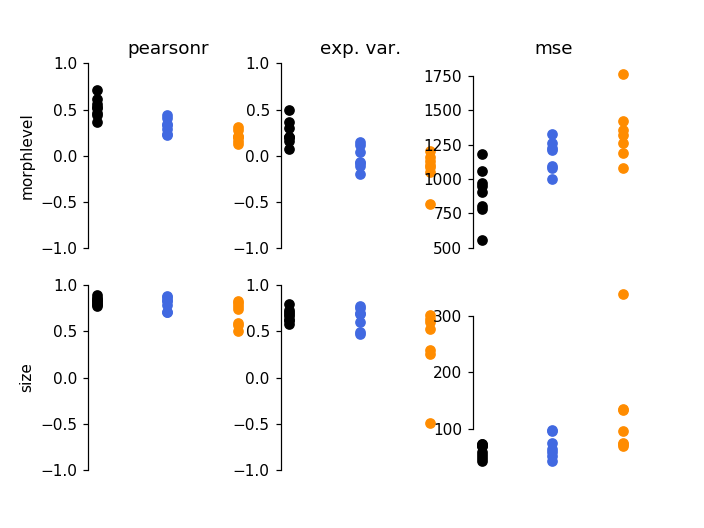

In [177]:
fig, axes = pl.subplots(2, 3, sharex=True)
for vi, visual_area in enumerate(visual_areas): #results.keys():
    values = [e.pearsons_r for e in results[visual_area]['morphlevel']]
    axes[0, 0].scatter([vi for _ in range(len(values))], values, color=area_colors[visual_area])
    values = [e.pearsons_r for e in results[visual_area]['size']]
    axes[1, 0].scatter([vi for _ in range(len(values))], values, color=area_colors[visual_area])
    axes[0, 0].set_title('pearsonr')
    axes[0, 0].set_ylabel('morphlevel')
    axes[1, 0].set_ylabel('size')
    axes[0, 0].set_ylim([-1, 1])
    axes[1, 0].set_ylim([-1, 1])

    values = [e.exp_var for e in results[visual_area]['morphlevel']]
    axes[0, 1].scatter([vi for _ in range(len(values))], values, color=area_colors[visual_area])
    values = [e.exp_var for e in results[visual_area]['size']]
    axes[1, 1].scatter([vi for _ in range(len(values))], values, color=area_colors[visual_area])
    axes[0, 1].set_title('exp. var.')
    axes[0, 1].set_ylim([-1, 1])
    axes[1, 1].set_ylim([-1, 1])

    values = [e.mse for e in results[visual_area]['morphlevel']]
    axes[0, 2].scatter([vi for _ in range(len(values))], values, color=area_colors[visual_area])
    values = [e.mse for e in results[visual_area]['size']]
    axes[1, 2].scatter([vi for _ in range(len(values))], values, color=area_colors[visual_area])
    axes[0, 2].set_title('mse')
    
sns.despine(bottom=True, trim=True)
for ax in axes.flat:
    ax.tick_params(which='both', axis='x', length=0)
    ax.set_xticklabels([])

In [144]:
exp.data.labels.shape

(214400, 8)

In [145]:
len(exp.data.labels['trial'].unique())

1600

In [146]:
len(trial_configs)

1440